Circulant embedding code

In [1]:
from math import *
import numpy as np
from numpy import matlib
import scipy
from scipy import sparse
from scipy.sparse import linalg
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

fft  = np.fft.fft
ifft = np.fft.ifft

def circulant_exp(N,dt,ell):
    t = np.arange(N)*dt; 
    c = np.exp(-np.abs(t) / ell)
    # embed in circulant matrix for sampling
    c_tilde = np.hstack([c,c[-2:0:-1]])
    # obtain 2 samples from N(0,C_tilde)
    N  = c_tilde.size;    d = ifft(c_tilde)*N
    xi = np.dot(np.random.randn(N,2), [1,1j])
    Z  = fft(np.multiply(d**0.5,xi)) / sqrt(N)
    X  = np.real(Z);    Y = np.imag(Z)
    # extract samples from N(0,C)
    N = c.size;    X = X[0:N];    Y = Y[0:N]
    return t,X,Y

Set up the PDE and the Euler-Murayama integration loop.

In [2]:
def spde_fd_n_exp(u0,T,L,N,J,epsilon,sigma,ell,fhandle):
    Dt = T/N;    t = np.linspace(0,T,N+1)
    h  = L/J;    e = np.ones(J + 1)
    A  = scipy.sparse.diags([-1,2,-1],[-1,0,1],
                         shape=(J+1,J+1),
                         format='csc')
    ind = np.arange(0,J + 1); A[0,1] = 2; A[-1,-2] = 2
    EE  = scipy.sparse.identity(ind.size,format='csc') + (Dt*epsilon/h**2)*A 
    ut  = np.zeros((J+1,t.size)) # initialize vectors
    ut[:,0] = u0;    u_n = u0[ind]
    EEinv = sparse.linalg.factorized(EE)
    
    for n in range(N):
        fu = fhandle(u_n)
        x,dW,dW2 = circulant_exp(ind.size,h,ell)
        u_new = EEinv(u_n + Dt * fu + sigma*sqrt(Dt)*dW) 
        ut[ind,n + 1] = u_new
        u_n = u_new
    return t,ut

def fNagumo(u):
    return u*(1 - u)*(u + 0.5)

Simulate and plot results.

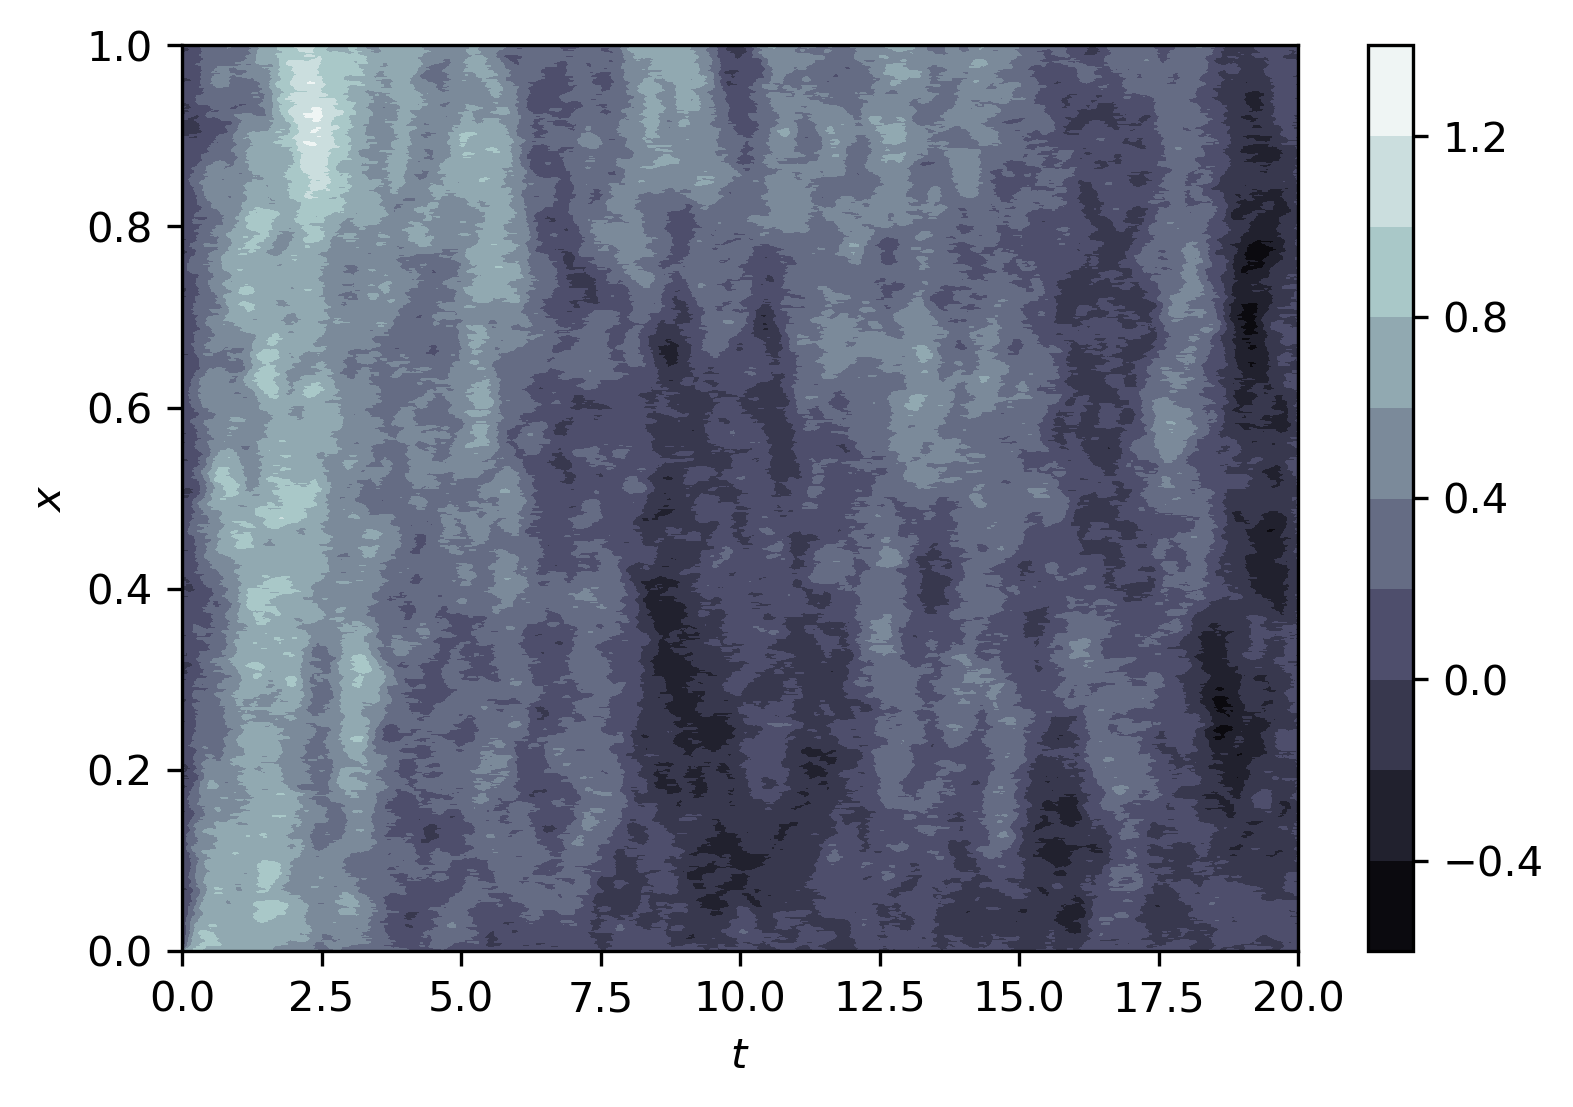

In [7]:
L = 20; J = 1024; x = np.linspace(0,a,J+1); u0 = 1/(1+np.exp(-(2-x)/sqrt(2)));
ell = 0.1; N = int(1e3); T = 1; epsilon = 1; sigma = 1;
t,ut = spde_fd_n_exp(u0,T,L,N,J,epsilon,sigma,ell,fNagumo)
[T,X] = np.meshgrid(t,x)
#
ax = plt.gca()
CS = ax.contourf(X,T,ut,10,cmap=plt.cm.bone)
s = plt.colorbar(CS)
s = ax.set_xlabel(r'$t$')
s = ax.set_ylabel(r'$x$')